# Bài tập cuối kỳ môn Machine Learning: Dự đoán xem một nhân viên sẽ nghỉ việc hay không

## Thư viện

In [359]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Define các hàm để in ra sự so sánh (nếu có)

In [360]:
def visualize_metrics(metrics):
    
    # List of classifiers and metrics
    classifiers = list(metrics.keys())
    metric_names = list(metrics[classifiers[0]].keys())

    
    bar_width = 0.15  # Set the width of the bars
    padding = 0.05  # Adjust the padding value as desired

    # Set the positions of the x-axis ticks
    x_pos = np.arange(len(classifiers))

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the bar chart size

    # Plot each metric as a group of bars
    for i, metric in enumerate(metric_names):
        metric_values = [metrics[classifier][metric] for classifier in classifiers]
        bar_positions = x_pos + ((bar_width + padding) * i)
        ax.bar(bar_positions, metric_values, bar_width, label=metric)

    # Set the labels and title
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x_pos + (((bar_width + padding) * (len(metric_names) - 1)) / 2))
    ax.set_xticklabels(classifiers)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


    
    
def print_metrics(accuracy, precision, recall, f1):
        print("Accuracy: " + str(accuracy))
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1-Score: " + str(f1))
        
def plot_loss_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    

## Phần 1 + Phần 4: Data Exploration + Data Preprocessing + Using Feature Selection for Reducing Overfitting

### Data cleaning

In [361]:
df = pd.DataFrame(pd.read_csv('Employee.csv'))
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [362]:
df.isna().sum()

# Không có giá trị null trong tập dữ liệu nên không cần xử lý "Missing Values"

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [363]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Xử lý dữ liệu trùng lặp.

### Data handling Categorical và Transformation


In [364]:
df['Education'].unique()


array(['Bachelors', 'Masters', 'PHD'], dtype=object)

In [365]:
df['City'].unique()

array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)

In [366]:
df['PaymentTier'].unique()

array([3, 1, 2], dtype=int64)

In [367]:
# Có 3 features thuộc dạng categorical nên cần phải chuyển đổi

df_dummies = pd.get_dummies(df, columns=['JoiningYear', 'Education', 'City', 'PaymentTier'])
df_dummies

,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,...,JoiningYear_2018,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
0,34,Male,No,0,0,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
1,28,Female,No,3,1,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,False
2,38,Female,No,2,0,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,True
3,27,Male,No,5,1,False,False,False,False,True,...,False,False,True,False,True,False,False,False,False,True
4,24,Male,Yes,2,1,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,Female,No,2,0,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
4647,30,Male,No,2,0,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,True
4649,37,Male,No,2,1,False,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
4650,27,Male,No,5,1,False,False,False,False,False,...,True,False,True,False,False,True,False,False,False,True


In [368]:
df_dummies.dtypes

Age                           int64
Gender                       object
EverBenched                  object
ExperienceInCurrentDomain     int64
LeaveOrNot                    int64
JoiningYear_2012               bool
JoiningYear_2013               bool
JoiningYear_2014               bool
JoiningYear_2015               bool
JoiningYear_2016               bool
JoiningYear_2017               bool
JoiningYear_2018               bool
Education_Bachelors            bool
Education_Masters              bool
Education_PHD                  bool
City_Bangalore                 bool
City_New Delhi                 bool
City_Pune                      bool
PaymentTier_1                  bool
PaymentTier_2                  bool
PaymentTier_3                  bool
dtype: object

In [369]:
le = LabelEncoder()

name = list(df_dummies.columns)
type = df_dummies.dtypes

for i in range(len(type)):
    if type[i] == 'object' or type[i] == 'bool':
        le.fit_transform(df_dummies[name[i]])
        df_dummies[name[i]] = le.transform(df_dummies[name[i]])
        
df_dummies

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\2166870924.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object' or type[i] == 'bool':
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\2166870924.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object' or type[i] == 'bool':
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\2166870924.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i]

,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,...,JoiningYear_2018,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
0,34,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,28,0,0,3,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,38,0,0,2,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,27,1,0,5,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
4,24,1,1,2,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,31,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4647,30,1,0,2,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
4649,37,1,0,2,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4650,27,1,0,5,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1


### Data Exploration

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'EverBenched'}>,
        <Axes: title={'center': 'ExperienceInCurrentDomain'}>,
        <Axes: title={'center': 'LeaveOrNot'}>],
       [<Axes: title={'center': 'JoiningYear_2012'}>,
        <Axes: title={'center': 'JoiningYear_2013'}>,
        <Axes: title={'center': 'JoiningYear_2014'}>,
        <Axes: title={'center': 'JoiningYear_2015'}>,
        <Axes: title={'center': 'JoiningYear_2016'}>],
       [<Axes: title={'center': 'JoiningYear_2017'}>,
        <Axes: title={'center': 'JoiningYear_2018'}>,
        <Axes: title={'center': 'Education_Bachelors'}>,
        <Axes: title={'center': 'Education_Masters'}>,
        <Axes: title={'center': 'Education_PHD'}>],
       [<Axes: title={'center': 'City_Bangalore'}>,
        <Axes: title={'center': 'City_New Delhi'}>,
        <Axes: title={'center': 'City_Pune'}>,
        <Axes: title={'center': 'PaymentTier_1'}>,
        <

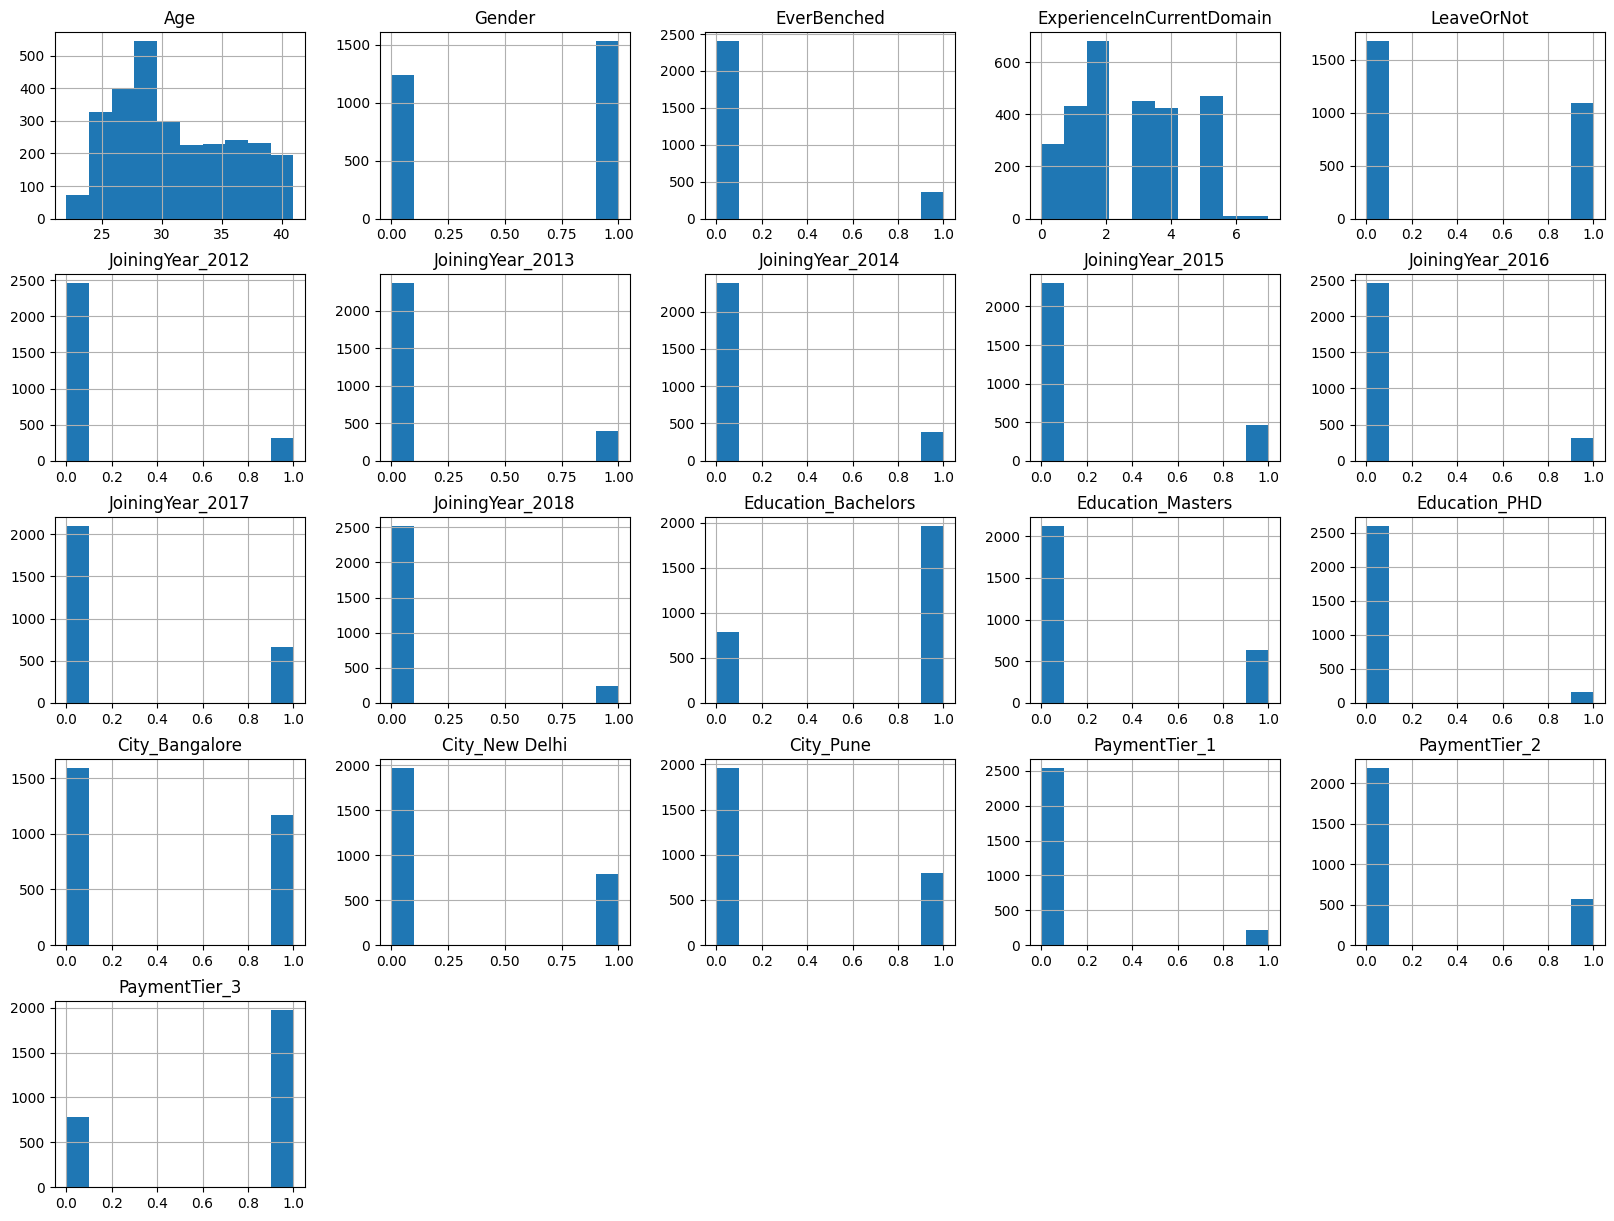

In [370]:
df_dummies.hist(figsize=(20, 15))

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\845636304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\845636304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\845636304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

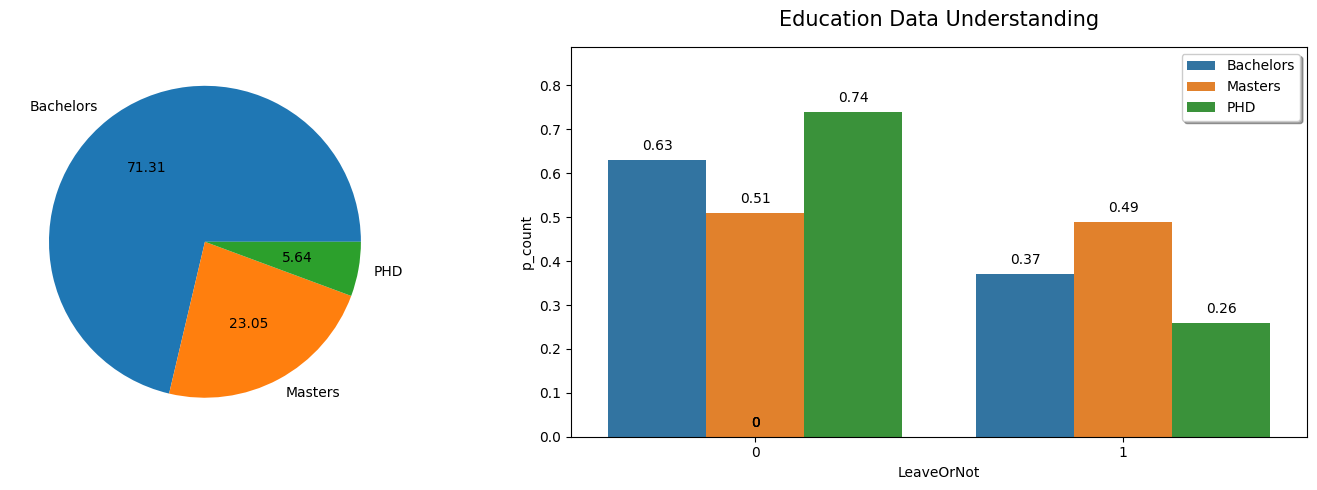

In [371]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên trình độ học vấn

data1=df.Education.value_counts().reset_index()
data2=df.groupby(['Education','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Education.unique():
    msg=data2[data2.Education==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Education'], autopct='%.2f')
ax[1].set_title('Education Data Understanding', fontsize=15, pad=15)

# Bar plot 
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Education', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\846651779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\846651779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\846651779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

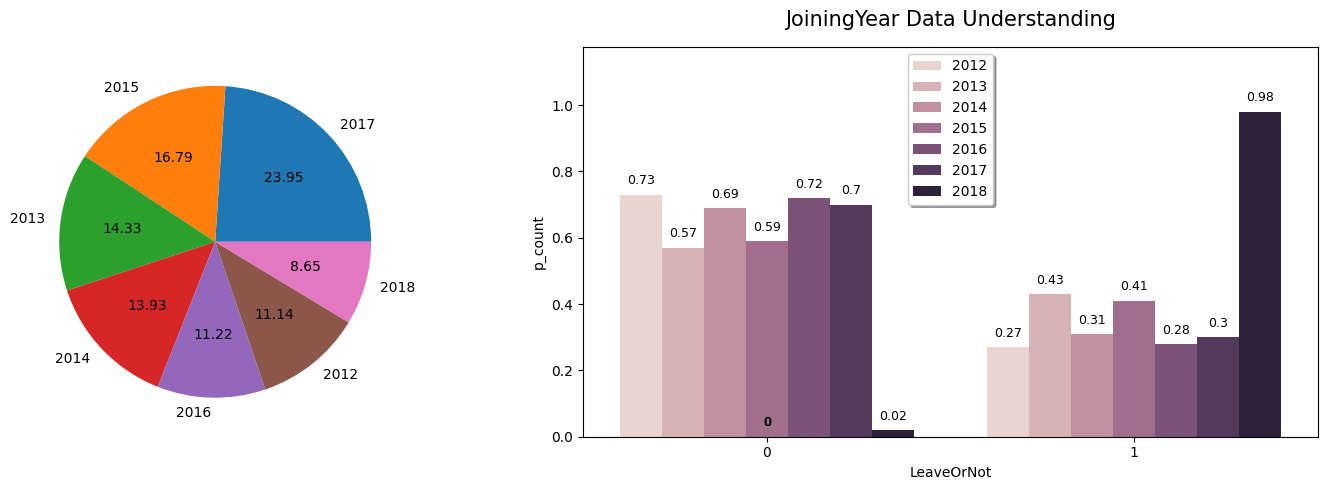

In [372]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên năm ứng tuyển

data1=df.JoiningYear.value_counts().reset_index()
data2=df.groupby(['JoiningYear','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.JoiningYear.unique():
    msg=data2[data2.JoiningYear==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['JoiningYear'], autopct='%.2f')
ax[1].set_title('JoiningYear Data Understanding', fontsize=15, pad=15)

# Bar plot 
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='JoiningYear', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\1945259697.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\1945259697.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\1945259697.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

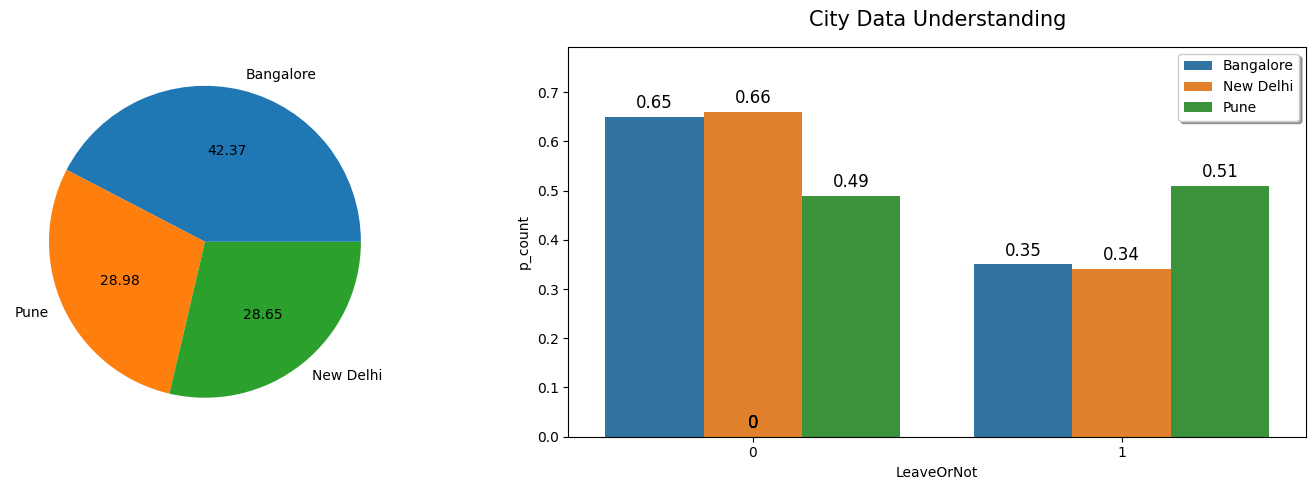

In [373]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên thành phố sinh sống

data1=df.City.value_counts().reset_index()
data2=df.groupby(['City','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.City.unique():
    msg=data2[data2.City==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['City'], autopct='%.2f')
ax[1].set_title('City Data Understanding', fontsize=15, pad=15)

# Bar plot 
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='City', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\2770285513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\2770285513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


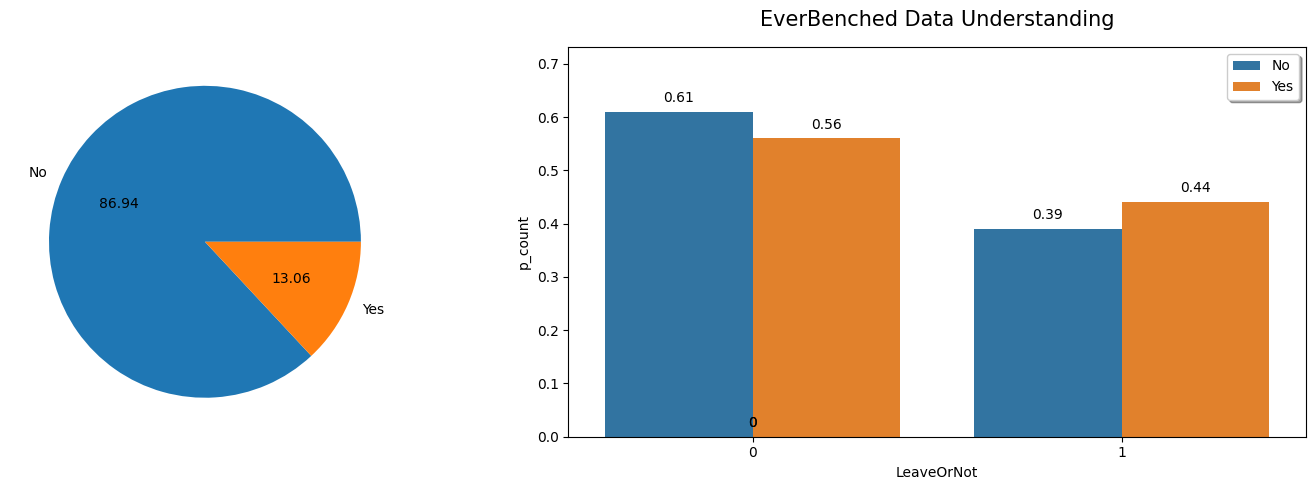

In [374]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên lịch sử thăng cấp

data1=df.EverBenched.value_counts().reset_index()
data2=df.groupby(['EverBenched','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.EverBenched.unique():
    msg=data2[data2.EverBenched==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['EverBenched'], autopct='%.2f')
ax[1].set_title('EverBenched Data Understanding', fontsize=15, pad=15)

# Bar plot 
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='EverBenched', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\3754372727.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
C:\Users\Thinh\AppData\Local\Temp\ipykernel_8464\3754372727.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)


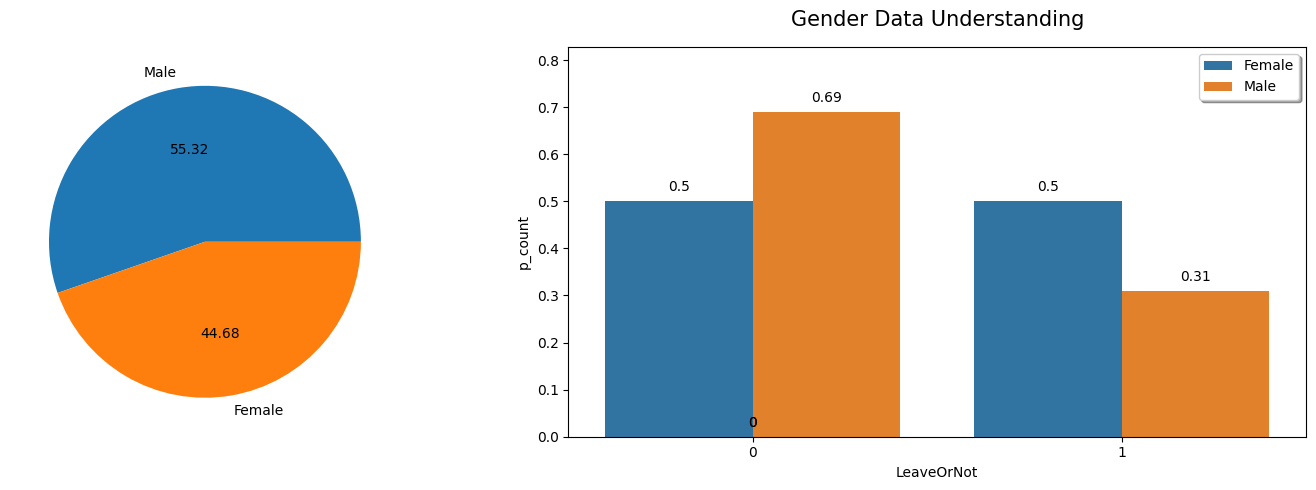

In [375]:
# xem tỉ lê số lượng nhân viên bỏ việc dựa trên giới tính

data1=df.Gender.value_counts().reset_index()
data2=df.groupby(['Gender','LeaveOrNot']).size().reset_index().rename(columns={0:'count'})
data2_=[]
for x in data2.Gender.unique():
    msg=data2[data2.Gender==x]
    msg['p_count']=np.round(msg['count']/msg['count'].sum(), 2)
    data2_.append(msg)
data2=pd.concat(data2_)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].pie(data1['count'], labels=data1['Gender'], autopct='%.2f')
ax[1].set_title('Gender Data Understanding', fontsize=15, pad=15)

# Bar plot 
bar_plot = sns.barplot(data=data2, x='LeaveOrNot', y='p_count', hue='Gender', ax=ax[1])

# Show the annotate on the top of barplot
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax[1].legend(shadow=True)
ax[1].set_ylim(ymin=0, ymax=data2['p_count'].max() + (data2['p_count'].max()*0.2))

plt.tight_layout()
plt.show()

### Sử dụng Pearson Corelation để xem điểm tương quang giữa các Feature

<Axes: >

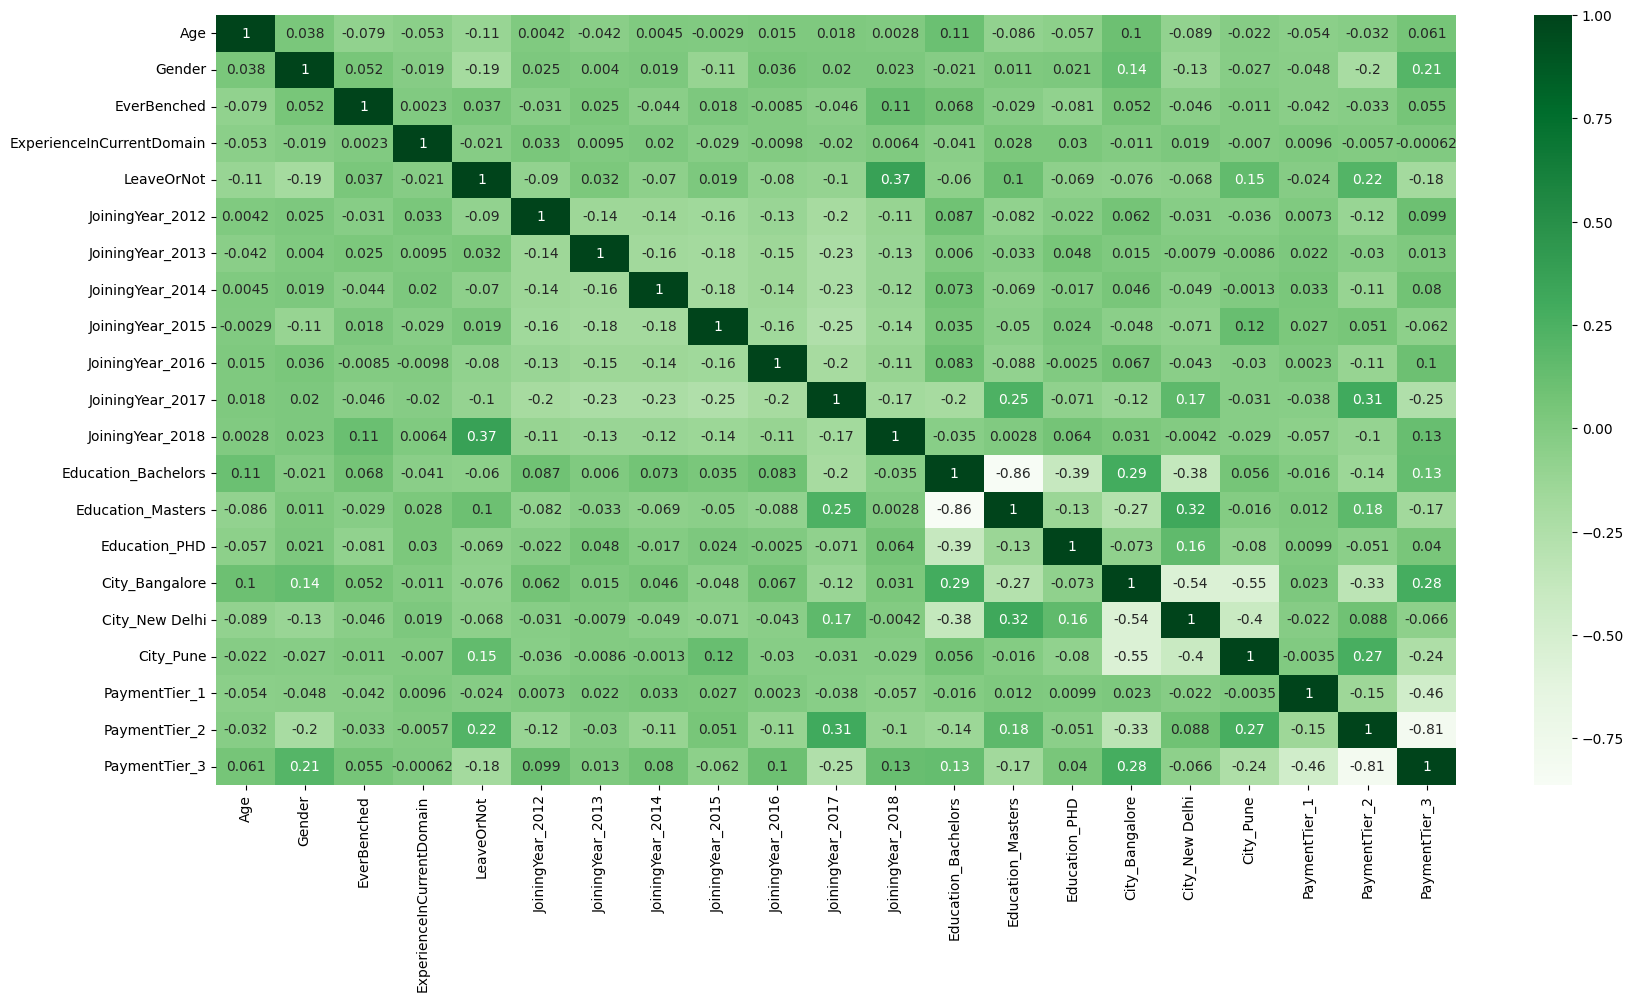

In [376]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap="Greens")

In [377]:
# # từ bản tương quan có thể thấy rằng bằng thạc sĩ hoặc cử nhân có tương quang tương đương nhau nên có thểm drop 1 trong 2
df_dummies.drop('Education_Bachelors', axis=1, inplace=True)
df_dummies.drop('City_Bangalore', axis=1, inplace=True)
df_dummies.drop('PaymentTier_2', axis=1, inplace=True)

df_dummies.head()

,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,JoiningYear_2012,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,Education_Masters,Education_PHD,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_3
0,34,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,28,0,0,3,1,0,1,0,0,0,0,0,0,0,0,1,1,0
2,38,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,27,1,0,5,1,0,0,0,0,1,0,0,1,0,0,0,0,1
4,24,1,1,2,1,0,0,0,0,0,1,0,1,0,0,1,0,1


#### Bài toán này không cần phải chuẩn hóa, nên bắt đầu tách dữ liệu để train mô hình


In [378]:
X = df_dummies.drop('LeaveOrNot', axis=1)
y = df_dummies['LeaveOrNot']

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.3)

## Phần 2: Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing;

### Các mô hình học máy cơ bản:

#### KNN

#### Linear Regression

#### Decision Tree

#### Naive Bayes

#### SVM

#### Logistic Regression

### Ứng dụng các mô hình học máy thuộc Ensemble Learing;

#### Gradient Boosting

In [380]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_f1 = f1_score(y_test, y_pred)

print_metrics(gb_accuracy, gb_precision, gb_recall, gb_f1)


Accuracy: 0.7759036144578313
Precision: 0.7791164658634538
Recall: 0.5969230769230769
F1-Score: 0.6759581881533101


#### AdaBoost

In [381]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

ada_accuracy = accuracy_score(y_test, y_pred)
ada_precision = precision_score(y_test, y_pred)
ada_recall = recall_score(y_test, y_pred)
ada_f1 = f1_score(y_test, y_pred)

print_metrics(ada_accuracy, ada_precision, ada_recall, ada_f1)


Accuracy: 0.7337349397590361
Precision: 0.696969696969697
Recall: 0.5661538461538461
F1-Score: 0.6247877758913412


#### Bagging

In [382]:
from sklearn.ensemble import BaggingClassifier

# Create a base classifier
base_classifier = DecisionTreeClassifier()

bagging_clf = BaggingClassifier(base_estimator=base_classifier)
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_pred)
bagging_precision = precision_score(y_test, y_pred)
bagging_recall = recall_score(y_test, y_pred)
bagging_f1 = f1_score(y_test, y_pred)

print_metrics(bagging_accuracy, bagging_precision, bagging_recall, bagging_f1)

Accuracy: 0.7337349397590361
Precision: 0.6830985915492958
Recall: 0.5969230769230769
F1-Score: 0.6371100164203612


c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


#### Random Forest

In [383]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print_metrics(rf_accuracy, rf_precision, rf_recall, rf_f1)

Accuracy: 0.7313253012048193
Precision: 0.6655844155844156
Recall: 0.6307692307692307
F1-Score: 0.6477093206951027


#### Voting Classifier

In [384]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Create individual classifiers
gb_clf = GradientBoostingClassifier()
lr_clf = LogisticRegression()

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf), ('lr', lr_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

voting_accuracy = accuracy_score(y_test, y_pred)
voting_precision = precision_score(y_test, y_pred)
voting_recall = recall_score(y_test, y_pred)
voting_f1 = f1_score(y_test, y_pred)

print_metrics(voting_accuracy, voting_precision, voting_recall, voting_f1)


Accuracy: 0.7710843373493976
Precision: 0.7626459143968871
Recall: 0.6030769230769231
F1-Score: 0.6735395189003437


c:\Users\Thinh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Stacking

In [385]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('gb', gb_clf)],
    final_estimator=lr_clf
)
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_pred)
stacking_precision = precision_score(y_test, y_pred)
stacking_recall = recall_score(y_test, y_pred)
stacking_f1 = f1_score(y_test, y_pred)

print_metrics(stacking_accuracy, stacking_precision, stacking_recall, stacking_f1)

Accuracy: 0.7771084337349398
Precision: 0.7734375
Recall: 0.6092307692307692
F1-Score: 0.6815834767641997


#### Hàm visualize_metrics sử dụng để so sánh hiệu suất của nhiều bộ phân loại (classifiers) khác nhau dựa trên các độ đo đánh giá như accuracy (độ chính xác), precision (độ chính xác dương tính), recall (độ phục hồi), và F1-score.

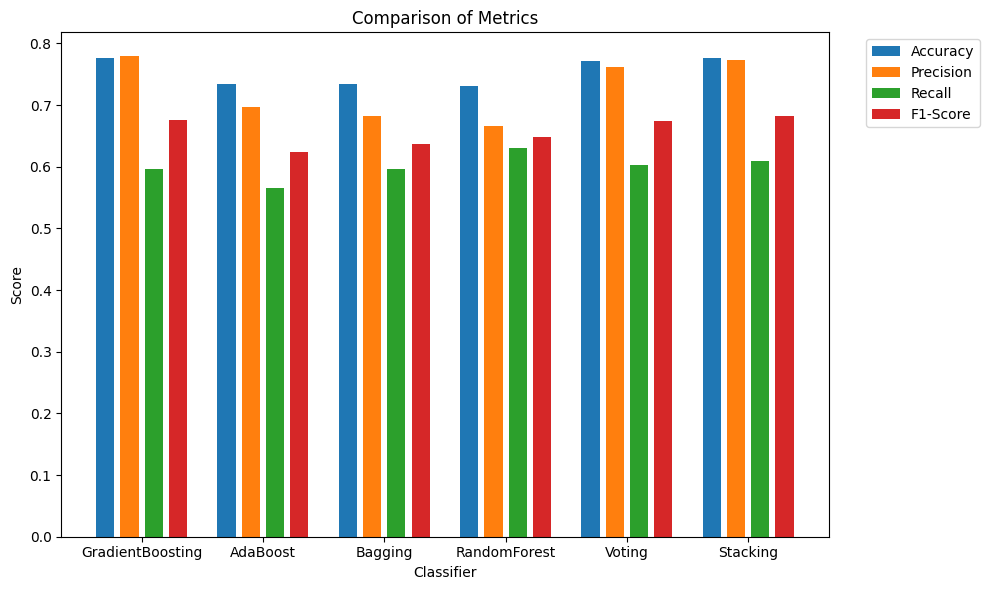

In [386]:

metrics = {
    'GradientBoosting': {
        'Accuracy': gb_accuracy,
        'Precision': gb_precision,
        'Recall': gb_recall,
        'F1-Score': gb_f1
    },
    
    'AdaBoost': {
        'Accuracy': ada_accuracy,
        'Precision': ada_precision,
        'Recall': ada_recall,
        'F1-Score': ada_f1
    },
    
    'Bagging': {
        'Accuracy': bagging_accuracy,
        'Precision': bagging_precision,
        'Recall': bagging_recall,
        'F1-Score': bagging_f1
    },
    
    'RandomForest': {
        'Accuracy': rf_accuracy,
        'Precision': rf_precision,
        'Recall': rf_recall,
        'F1-Score': rf_f1
    },
    
    'Voting': {
        'Accuracy': voting_accuracy,
        'Precision': voting_precision,
        'Recall': voting_recall,
        'F1-Score': voting_f1
    },
    
    'Stacking': {
        'Accuracy': stacking_accuracy,
        'Precision': stacking_precision,
        'Recall': stacking_recall,
        'F1-Score': stacking_f1
    }
}

visualize_metrics(metrics=metrics)


## Phần 3: Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán

### Feed Forward Neurl Network


Epoch 1/100
61/61 [==============================] - 1s 4ms/step - loss: 0.7070 - accuracy: 0.5760 - val_loss: 0.7068 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6531 - accuracy: 0.6138 - val_loss: 0.6288 - val_accuracy: 0.7157
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.6253 - accuracy: 0.6406 - val_loss: 0.5998 - val_accuracy: 0.6819
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.6960 - val_loss: 0.6353 - val_accuracy: 0.6229
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7115 - val_loss: 0.5789 - val_accuracy: 0.7253
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.7296 - val_loss: 0.5624 - val_accuracy: 0.7398
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 0.5411 - accuracy: 0.7482 - val_loss: 0.5566 - val_accuracy: 0.7494
Epoch 8/100
6

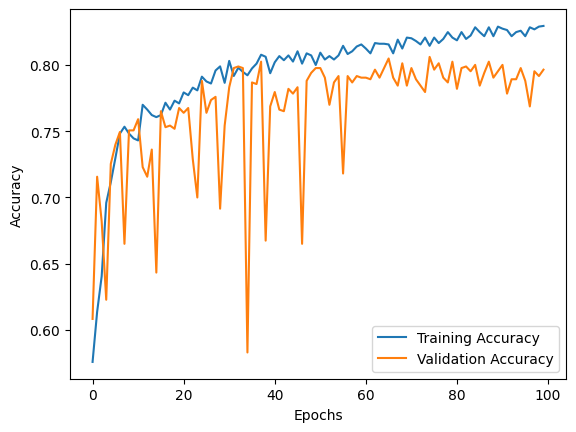

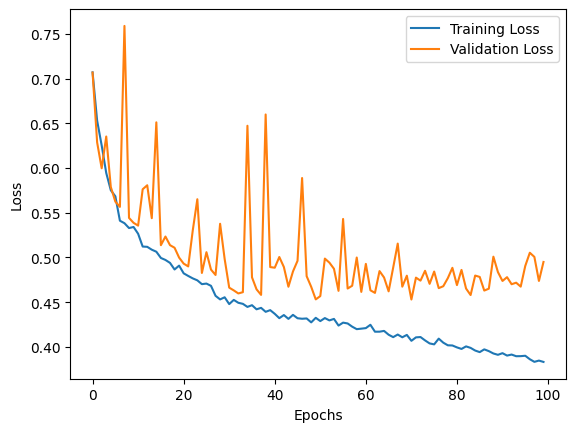

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 64)                1152      
                                                                 
 dense_131 (Dense)           (None, 64)                4160      
                                                                 
 dense_132 (Dense)           (None, 32)                2080      
                                                                 
 dense_133 (Dense)           (None, 1)                 33        
                                                                 
Total params: 7425 (29.00 KB)
Trainable params: 7425 (29.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [387]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', use_bias=True),
    tf.keras.layers.Dense(64, activation='relu', use_bias=True),
    tf.keras.layers.Dense(32, activation='relu', use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_FFNW.compile(loss="binary_crossentropy", metrics='accuracy')

history_FFNW = model_FFNW.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

plot_accuracy_history(history_FFNW)
plot_loss_history(history_FFNW)

print(model_FFNW.summary())

In [388]:
print(model_FFNW.evaluate(X_test, y_test, verbose=0))

[0.49497324228286743, 0.7963855266571045]


### Reccurent Neural Network

In [389]:

model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 64, activation='relu', return_sequences=True, input_shape= (X_train.shape[1],1)),
    tf.keras.layers.LSTM(units = 64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(units = 1, activation='sigmoid'),
])

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_RNN = model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
61/61 [==============================] - 4s 21ms/step - loss: 0.6700 - accuracy: 0.6039 - val_loss: 0.6733 - val_accuracy: 0.6084
Epoch 2/100
61/61 [==============================] - 1s 14ms/step - loss: 0.6460 - accuracy: 0.6282 - val_loss: 0.6137 - val_accuracy: 0.6795
Epoch 3/100
61/61 [==============================] - 1s 14ms/step - loss: 0.5879 - accuracy: 0.7089 - val_loss: 0.5876 - val_accuracy: 0.7229
Epoch 4/100
61/61 [==============================] - 1s 14ms/step - loss: 0.5450 - accuracy: 0.7337 - val_loss: 0.5639 - val_accuracy: 0.7036
Epoch 5/100
61/61 [==============================] - 1s 14ms/step - loss: 0.5369 - accuracy: 0.7415 - val_loss: 0.5329 - val_accuracy: 0.7494
Epoch 6/100
61/61 [==============================] - 1s 14ms/step - loss: 0.5180 - accuracy: 0.7508 - val_loss: 0.5269 - val_accuracy: 0.7518
Epoch 7/100
61/61 [==============================] - 1s 14ms/step - loss: 0.5101 - accuracy: 0.7658 - val_loss: 0.5271 - val_accuracy: 0.7518
Epoch 

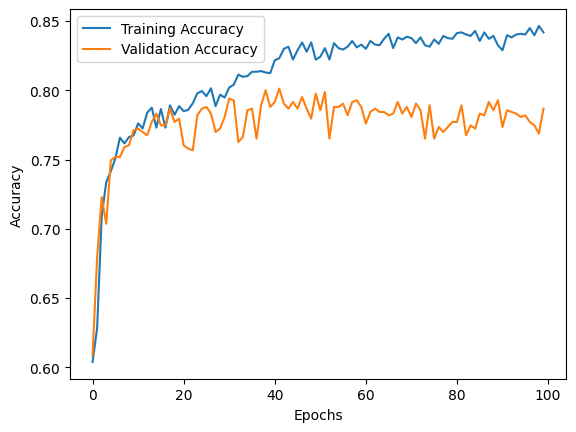

In [390]:
plot_accuracy_history(history_RNN)

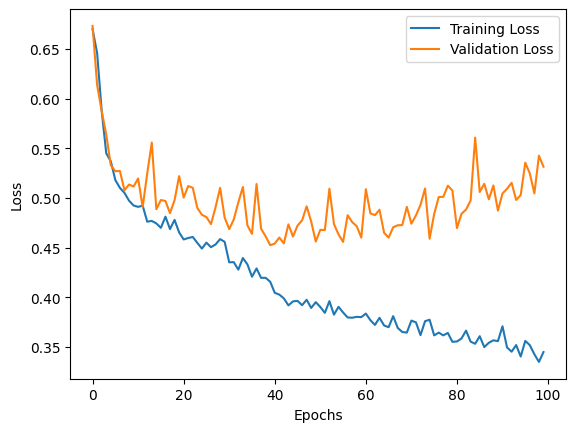

In [391]:
plot_loss_history(history_RNN)

In [392]:
print(model_RNN.evaluate(X_test, y_test, verbose=0))

[0.5314285159111023, 0.7867469787597656]
